In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from typing import List, Optional, Union

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

ModuleNotFoundError: No module named 'tensorflow_datasets'

In [3]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for i, (image, label) in enumerate(train_ds.take(9)):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(image)
#     plt.title(int(label))
#     plt.axis("off")

In [4]:
# img, label = next(train_ds.__iter__())
# print(img.numpy().shape)
# print(label.numpy())

## Store images in TFRecords

In [3]:
import cv2

def np_img_to_bytes(np_img):
    """ Encode np image into bytes string. 
    https://programmer.group/opencv-python-cv2.imdecode-and-cv2.imencode-picture-decoding-and-coding.html
    Note! cv2 assumes images are in BGR rather RGB
    """
    _, img_encode = cv2.imencode('.png', cv2.cvtColor(np_img, cv2.COLOR_RGB2BGR))
    # img_encode = np.array(img_encode)
    img_bytes = img_encode.tobytes()
    return img_bytes

In [4]:
import os
import sys
from pathlib import Path
fdir = Path.cwd()
print(fdir)
sys.path.append(str(fdir/'../src'))

from tf_utils import (calc_records_in_tfr_folder,
                      calc_examples_in_tfrecord,
                      calc_records_in_tfr_files,
                      _float_feature, _bytes_feature, _int64_feature)
# Global
MAIN_APPDIR = fdir/'../apps'
DATADIR = fdir/'../data'
FILENAME = 'annotations.csv'
TILES_DIR = DATADIR/'tiles_png'
TFR_DIR = DATADIR/'cats_dogs_tfrecords'

os.makedirs(TFR_DIR, exist_ok=True)

/vol/ml/apartin/projects/pdx-histo/nbs


In [5]:
GE_LEN = 100

def cat_and_dogs_to_tfrecords(ds, samples_per_tfr=None, set_type='tr', verbose=False):
    """ Save cats and dogs images in tfrecords. """
    tfr_id = 0
    
    if samples_per_tfr is None:
        if verbose:
            print('Create writer.')
        tfr_fname = TFR_DIR/f'{set_type}.tfrecord'
        writer = tf.io.TFRecordWriter(str(tfr_fname))   
    
    for i, (img, label) in enumerate(ds):

        if isinstance(samples_per_tfr, int) and samples_per_tfr > 0:
            # samples_per_tfr = 500
            # Create tfrecord every n_samples
            if i % samples_per_tfr == 0:
                if i > 0:
                    writer.close()
                    if verbose:
                        print('Closed previous writer.')

                if verbose:
                    print(f'Item {i}')
                # print('Create writer')
                tfr_id += 1
                tfr_fname = TFR_DIR/f'{set_type}_{tfr_id}.tfrecord'
                writer = tf.io.TFRecordWriter(str(tfr_fname))

        img_bytes = np_img_to_bytes(img.numpy())

        if label == 0:
            label = 10
        feature = {
            'ge_vec': _float_feature(list(np.random.random(GE_LEN))),
            'Response': _int64_feature(np.random.randint(2)),
            'ctype_label': _int64_feature(np.random.randint(2)),
            'image_raw': _bytes_feature(img_bytes),
            'img_id': _bytes_feature(bytes(f'{set_type}_{i}', 'utf-8')),
            'label': _int64_feature(label),
        }
        ex = tf.train.Example(features=tf.train.Features(feature=feature))
        writer.write(ex.SerializeToString())

    writer.close()
    if verbose:
        print('Closed final writer.')

In [6]:
cat_and_dogs_to_tfrecords(train_ds, samples_per_tfr=500, set_type='tr', verbose=False)
cat_and_dogs_to_tfrecords(validation_ds, samples_per_tfr=500, set_type='vl', verbose=False)
cat_and_dogs_to_tfrecords(test_ds, samples_per_tfr=500, set_type='te', verbose=False)

In [7]:
# Feature specs (used to read an example from tfrecord)
FEA_SPEC = {
    'ge_vec':      tf.io.FixedLenFeature(shape=(GE_LEN,), dtype=tf.float32, default_value=None),  
    'Response':    tf.io.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),   
    'ctype_label': tf.io.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
    'image_raw':   tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),   
    'img_id':      tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 
    'label':       tf.io.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
}

In [8]:
# Summary of tfrecords
tr_tfr_files = [str(f) for f in sorted(TFR_DIR.glob('tr_*.tfrec*'))]
vl_tfr_files = [str(f) for f in sorted(TFR_DIR.glob('vl_*.tfrec*'))]
te_tfr_files = [str(f) for f in sorted(TFR_DIR.glob('te_*.tfrec*'))]
print('Number of tfrecords the folder:', len(tr_tfr_files))

calc_records_in_tfr_folder(tfr_dir=TFR_DIR)
calc_records_in_tfr_files(tr_tfr_files)
calc_records_in_tfr_files(vl_tfr_files)
calc_records_in_tfr_files(te_tfr_files)

Number of tfrecords the folder: 19
Number of examples in all tfrecords in the folder: 13957
Number of examples in all tfrecords in the folder: 9305
Number of examples in all tfrecords in the folder: 2326
Number of examples in all tfrecords in the folder: 2326


In [9]:
im_list = []
id_list = []
lb_list = []
ctl_list = []

# All tfrecord
ds = tf.data.TFRecordDataset(te_tfr_files)

# ds = tf.data.Dataset.from_tensor_slices(te_tfr_fnames)
# ds = ds.interleave(lambda x: tf.data.TFRecordDataset(x), cycle_length=4)

# Subset of tfrecords
# ds = tf.data.TFRecordDataset(filenames=te_tfr_fnames[0])  # label 1 (digestive/gastrointestinal)
# ds = tf.data.TFRecordDataset(filenames=te_tfr_fnames[2])  # label 10 (squamous)
# ds = tf.data.TFRecordDataset(filenames=te_tfr_fnames[:3])  # get 3 tfrecords

# ds = ds.shuffle(buffer_size=300, seed=None)  # this shuffles the items within ALL the loaded tfrecords

# Iterate over all elements of the tfrecords
for i, ex in enumerate(ds):
    ex = tf.io.parse_single_example(ex, features=FEA_SPEC)
    im_list.append(ex['image_raw'].numpy())
    id_list.append(ex['img_id'].numpy())
    lb_list.append(ex['label'].numpy())
    ctl_list.append(ex['ctype_label'].numpy())

print('Number of files:   ', len(tr_tfr_files))
print('Number of elements:', len(id_list))
print('Unique label:      ', np.unique(lb_list))
print('bincount:          ', np.bincount(lb_list))
print('\ntile id:\n{}'.format(id_list[:10]))

del ds, ex, im_list, id_list, lb_list, ctl_list

Number of files:    19
Number of elements: 2326
Unique label:       [ 1 10]
bincount:           [   0 1149    0    0    0    0    0    0    0    0 1177]

tile id:
[b'te_0', b'te_1', b'te_2', b'te_3', b'te_4', b'te_5', b'te_6', b'te_7', b'te_8', b'te_9']


In [10]:
# ex = next(tf.data.TFRecordDataset(te_tfr_files).take(1).__iter__())
# ex = tf.io.parse_single_example(ex, features=FEA_SPEC)
# print(ex.keys())
# im = tf.image.decode_jpeg(ex['image_raw'], channels=3)

In [11]:
def prepare_image(img, augment=True, img_dim=224):
    """
    Prepare single image for training. 
    Deotte.
    www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords/
    """
    img = tf.image.decode_jpeg(img, channels=3)
    # img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize(images=img, size=(img_dim, img_dim),
                          method=tf.image.ResizeMethod.BILINEAR,
                          preserve_aspect_ratio=False)    
    if augment:
        # https://www.tensorflow.org/api_docs/python/tf/image/random_flip_up_down
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
    return img

In [12]:
def read_tfr_example(ex, augment=True, img_dim=224):
    """
    Read and parse a single example from a tfrecord, and prepare
    inputs and outputs for TF model training.
    """
    # print('Inside read_tfr_example() ...')
    
    ex = tf.io.parse_single_example(ex, FEA_SPEC)

    # Inputs
    img = ex['image_raw']
    img = prepare_image(img, augment=augment, img_dim=img_dim)  # Deotte
    inputs = {'img': img}

    # Outputs
    label = tf.cast(ex['label'], tf.int64)
    outputs = {'label': label}

    return inputs, outputs

In [13]:
def get_dataset(files: List[str],
                cache: bool=True,
                shuffle: bool=False,
                repeat: Union[bool, int]=False, 
                augment: bool=False,
                prefetch: Optional[int]=1,
                labeled: bool=False,
                batch_size: int=32,
                img_dim: int=224,
                seed=None):
    """ Create and return tf dataset using tfrecord files passed in files. """
    # print('Inside get_dataset() ...')
    
    # -----------------------------------------------------------------------------
    # https://github.com/tensorflow/tensorflow/issues/14857 

    # 1. Randomly shuffle the entire data once using a MapReduce/Spark/Beam/etc. job
    #    to create a set of roughly equal-sized files ("shards").

    shards = tf.data.Dataset.from_tensor_slices(files)  # data shards

    # 2. In each epoch:
    # i. Randomly shuffle the list of shard filenames, using Dataset.list_files(...).shuffle(num_shards).

    shards = shards.shuffle(len(shards), seed=seed)  # shuffle the list of shard filenames
    # shards = shards.repeat()

    # ii. Use dataset.interleave(lambda filename: tf.data.TextLineDataset(filename), cycle_length=N)
    #     to mix together records from N different shards.

    cycle_length = 8  # default: tf.data runtime decides what it should be based on available CPU
    # cycle_length = 1
    block_length = 1  # default: 1
    num_parallel_calls = None  # default: default behavior is to fetch inputs from cycle elements synchronously with no parallelism
    dataset = shards.interleave(
        lambda x: tf.data.TFRecordDataset(x, num_parallel_reads=None),
        cycle_length=cycle_length,
        block_length=block_length,
        num_parallel_calls=num_parallel_calls,
        deterministic=False
    )
    
    # instead of step 2.ii.
    # dataset = tf.data.TFRecordDataset(shards, num_parallel_reads=None)
    
    # (ap) it seems that cache comes after TFRecordDataset()
    if cache:
        dataset = dataset.cache()
    
    # iii. Use dataset.shuffle(B) to shuffle the resulting dataset. Setting B might require some experimentation,
    #      but you will probably want to set it to some value larger than the number of records in a single shard.
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=2048)  # (ap) shuffles the examples in the relevant filenames    

    # -----------------------------------------------------------------------------

    # (ap) why do we need repeat if we specify epochs in the model.fit() ??
    if repeat is True:
        dataset = dataset.repeat()
    elif isinstance(repeat, int) and repeat > 0:
        dataset = dataset.repeat(repeat)

    # num_parallel_calls = AUTO
    num_parallel_calls = 8
    # num_parallel_calls = None
    dataset = dataset.map(lambda ex: read_tfr_example(ex, augment=augment, img_dim=img_dim),
                num_parallel_calls=num_parallel_calls)

    dataset = dataset.batch(batch_size)

    # https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch
    # ds = ds.prefetch(buffer_size=AUTO)
    if prefetch is not None:
        dataset = dataset.prefetch(buffer_size=prefetch)
    return dataset

In [14]:
# -----------------------------------------------
# Read single tfrecord and explore single example
# -----------------------------------------------
# ds = tf.data.TFRecordDataset(filenames=tr_tfr_fnames)
# ds = ds.map(lambda ex: read_tfr_example(ex, augment=True))
kwargs = {'batch_size': 32,
          'shuffle': True,
          'augment': True,
          'repeat': False,
          'prefetch': 5,
          'img_dim': 150,
          'seed': None}

ds = get_dataset(te_tfr_files, **kwargs)

# Take an example
ex = next(ds.take(count=1).__iter__())  # creates Dataset with at most 'count' elements from this dataset.
# ex = next(ds.__iter__())
print('Inputs: ', ex[0].keys())
print('Outputs:', ex[1].keys())

print('\nInput features:')
for i, fea_name in enumerate(ex[0].keys()):
    print(fea_name, ex[0][fea_name].numpy().shape)

print('\nOutputs:')
for i, out_name in enumerate(ex[1].keys()):
    print(out_name, ex[1][out_name].numpy())

Inputs:  dict_keys(['img'])
Outputs: dict_keys(['label'])

Input features:
img (32, 150, 150, 3)

Outputs:
label [10 10  1  1 10  1  1  1  1  1  1  1  1  1  1  1 10  1 10 10 10 10 10 10
  1 10  1  1 10  1  1  1]


In [15]:
del ds, ex

kwargs = {'batch_size': 32,
          'shuffle': True,
          'augment': False,
          'repeat': False,
          'prefetch': 10,
          'img_dim': 150,
          'seed': None}

ds_tr = get_dataset(tr_tfr_files, **kwargs)
ds_vl = get_dataset(vl_tfr_files, **kwargs)
ds_te = get_dataset(te_tfr_files, **kwargs)

In [16]:
# images, labels = next(ds_te.take(count=1).__iter__())  # creates Dataset with at most 'count' elements from this dataset.
# print('Inputs: ', images['img'].shape)
# print('Outputs:', labels['label'].shape)

In [17]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [18]:
# for i, (images, labels) in enumerate(ds_tr.take(1)):

#     plt.figure(figsize=(10, 10))
    
#     first_image = images['img'].numpy()[0]
    
#     for ii in range(9):
#         ax = plt.subplot(3, 3, ii + 1)
#         augmented_image = data_augmentation(
#             tf.expand_dims(first_image, 0), training=True
#         )
#         # plt.imshow(augmented_image[0].numpy().astype("int32"))
#         plt.imshow(augmented_image[0].numpy())
#         plt.title(int(labels['label'][i]))
#         plt.axis("off")

In [21]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3), name='img')
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, name='label')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization_1 (Normalizati (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
label (Dense)                (None, 1)                

In [22]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)
# loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),

epochs = 20
model.fit(ds_tr, epochs=epochs, validation_data=ds_vl)

Epoch 1/20
291/291 [==============================] - 9s 31ms/step - loss: 0.0000e+00 - binary_accuracy: 0.5007 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.4948
Epoch 2/20
291/291 [==============================] - 9s 29ms/step - loss: 0.0000e+00 - binary_accuracy: 0.5017 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.4948
Epoch 3/20
291/291 [==============================] - 9s 29ms/step - loss: 0.0000e+00 - binary_accuracy: 0.5017 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.4948
Epoch 4/20
291/291 [==============================] - 9s 29ms/step - loss: 0.0000e+00 - binary_accuracy: 0.5017 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.4948
Epoch 5/20
291/291 [==============================] - 9s 30ms/step - loss: 0.0000e+00 - binary_accuracy: 0.5017 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.4948
Epoch 6/20
291/291 [==============================] - 9s 30ms/step - loss: 0.0000e+00 - binary_accuracy: 0.5017 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.4948
Epoch 7/20

In [2]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

NameError: name 'train_ds' is not defined

In [13]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [14]:
images, labels = next(train_ds.take(1).__iter__())
print(images.shape)
print(labels.shape)

(32, 150, 150, 3)
(32,)


0


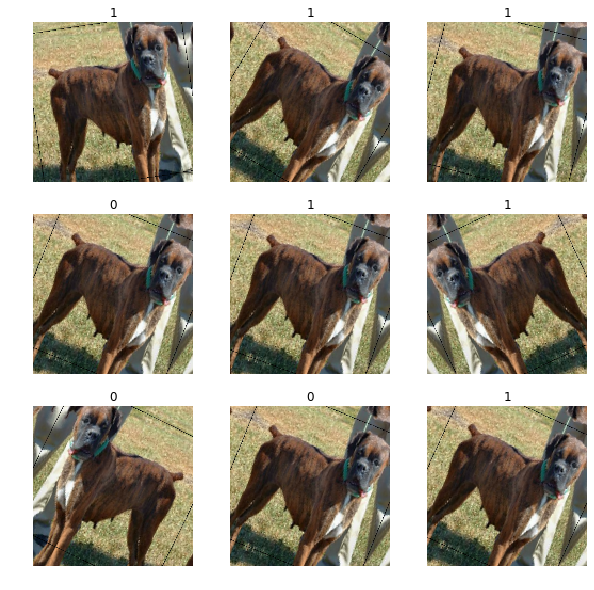

In [10]:
for i, (images, labels) in enumerate(train_ds.take(1)):
    print(i)
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for ii in range(9):
        ax = plt.subplot(3, 3, ii + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [23]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3), name='img')
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, name='label')(x)
model = keras.Model(inputs, outputs)

model.summary()

ResourceExhaustedError: OOM when allocating tensor with shape[1,1,728,728] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add]

In [12]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 11s 38ms/step - loss: 0.1679 - binary_accuracy: 0.9262 - val_loss: 0.0888 - val_binary_accuracy: 0.9690
Epoch 2/20
291/291 [==============================] - 10s 33ms/step - loss: 0.1189 - binary_accuracy: 0.9483 - val_loss: 0.0813 - val_binary_accuracy: 0.9699
Epoch 3/20
291/291 [==============================] - 10s 33ms/step - loss: 0.1150 - binary_accuracy: 0.9526 - val_loss: 0.0903 - val_binary_accuracy: 0.9647
Epoch 4/20
291/291 [==============================] - 10s 33ms/step - loss: 0.1105 - binary_accuracy: 0.9530 - val_loss: 0.0804 - val_binary_accuracy: 0.9678
Epoch 5/20
291/291 [==============================] - 10s 34ms/step - loss: 0.1094 - binary_accuracy: 0.9544 - val_loss: 0.0749 - val_binary_accuracy: 0.9703
Epoch 6/20
291/291 [==============================] - 10s 34ms/step - loss: 0.0987 - binary_accuracy: 0.9592 - val_loss: 0.0817 - val_binary_accuracy: 0.9695
Epoch 7/20
291/291 [==============================] 

In [14]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

291/291 [==============================] - 43s 148ms/step - loss: 0.0731 - binary_accuracy: 0.9715 - val_loss: 0.0553 - val_binary_accuracy: 0.9776
Epoch 2/10
291/291 [==============================] - 43s 147ms/step - loss: 0.0621 - binary_accuracy: 0.9746 - val_loss: 0.0497 - val_binary_accuracy: 0.9798
Epoch 3/10
291/291 [==============================] - 44s 152ms/step - loss: 0.0498 - binary_accuracy: 0.9804 - val_loss: 0.0478 - val_binary_accuracy: 0.9807
Epoch 4/10
291/291 [==============================] - 44s 153ms/step - loss: 0.0361 - binary_accuracy: 0.9865 - val_loss: 0.0493 - val_binary_accuracy: 0.9811
Epoch 5/10
291/291 [==============================] - 43s 147ms/step - loss: 0.0280 - binary_accuracy: 0.9890 - val_loss: 0.0443 - val_binary_accuracy: 0.9819
Epoch 6/10
291/291 [==============================] - 43s 148ms/step - loss: 0.0239 - binary_accuracy: 0.9909 - val_loss: 0.0507 - val_binary_accuracy: 0.9832
Epoch 7/10
291/291 [==============================] - 43s

In [ ]:
# Utils for transfer learing with Keras
def print_trainable_layers(model, print_all=False):
    """ Print the trainable state of layers. """
    print('Trainable layers:')
    for layer in model.layers:
        if layer.trainable:
            print(layer.name, layer.trainable)
        if not layer.trainable and print_all:
            print(layer.name, layer.trainable)

            
def freeze_layers(model, freeze_up_to='all'):
    """ Freeze up to layer freeze_up_to, including! """
    # freeze_layers = ['1', '2', '3', '4']
    if freeze_up_to=='all':
        for layer in model.layers:
            layer.trainable = False

    #for layer in model.layers:
    #    if any([True for i in layers_ids if i in layer.name]):
    #        layer.trainable = False
    for layer in model.layers:
        # if freeze_up_to.lower() != layer.name.lower():
        if freeze_up_to.lower() not in layer.name.lower():
            layer.trainable = False
        else:
            layer.trainable = False
            break

def pop_layers(model, keep_up_to):
    # pop_layers = ['4', '5', 'outputs']
    model_layers = model.layers
    #for layer in model_layers[::-1]:
    #    if any([True for i in layers_ids if i in layer.name]):
    #        model.layers.pop()  
    
    for layer in model_layers[::-1]:
        # if keep_up_to.lower() != layer.name.lower():
        if keep_up_to.lower() not in layer.name.lower():
            model.layers.pop()
        else:
           break